In [1]:
import json
import time
import os
import pickle
import copy
from tqdm import tqdm
import shutil
import cv2
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision.models as models
import matplotlib.pyplot as plt

### Load data

In [3]:
train_data = pd.read_csv("train_data.csv")
val_data = pd.read_csv("validation_data.csv")

In [4]:
train_data.head()

,name,label
0,video134-02-frame87.jpg,"[14, 7, 1, 0, 0, 1]"
1,video178-01-frame143.jpg,"[2, 5, 10, 4, 0, 2]"
2,video138-01-frame84.jpg,"[14, 2, 16, 2, 3, 0]"
3,video127-01-frame11.jpg,"[7, 5, 16, 2, 10, 0]"
4,video145-02-frame22.jpg,"[14, 2, 0, 0, 0, 2]"


In [5]:
with open('label.pkl', 'rb') as lf:
    all_label = pickle.load(lf)

In [6]:
where_unique, who_unique, recommend_place_unique, recommend_doing_unique, recommend_eat_unique, etc_unique  = all_label[0], all_label[1], all_label[2], all_label[3], all_label[4], all_label[5]

### Create Custom Dataset class
- 우리가 갖고있는 데이터에 맞게 Dataset을 구현해서 사용

In [7]:
class MultiTaskDataset(Dataset):
    def __init__(self, root_dir, df, transform=None):
        self.root_dir = root_dir
        self.name = list(df.name)
        self.label = [json.loads(x) for x in list(df.label)]
        self.transform = transform

    def __len__(self):
        return len(self.name)

    def __getitem__(self, index):
        # dealing with the images
        img_name = self.name[index]
        img = Image.open(os.path.join(self.root_dir, img_name)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # dealing with the labels
        labels = self.label[index]
        where = torch.tensor(int(labels[0]), dtype=torch.int64)
        who = torch.tensor(int(labels[1]), dtype=torch.int64)
        recommend_place = torch.tensor(int(labels[2]), dtype=torch.int64)
        recommend_doing = torch.tensor(int(labels[3]), dtype=torch.int64)
        recommend_eat = torch.tensor(int(labels[4]), dtype=torch.int64)
        etc = torch.tensor(int(labels[5]), dtype=torch.int64)
        
        return img, (where, who, recommend_place, recommend_doing, recommend_eat, etc), img_name

    def show(self, index):
        x,y,z = self.__getitem__(index)
        where, who, recommend_place, recommend_doing, recommend_eat, etc = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {} {} {} {} {}".format(where_unique[where.item()], who_unique[who.item()], recommend_place_unique[recommend_place.item()], recommend_doing_unique[recommend_doing.item()], recommend_eat_unique[recommend_eat.item()], etc_unique[etc.item()]))

### Implement a ResNet model

In [8]:
class MultiTaskResnet34(nn.Module):
    def __init__(self, where_classnum, who_classnum, place_classnum, doing_classnum, eat_classnum, etc_classnum):
        super(MultiTaskResnet34, self).__init__()
        self.model_resnet = models.resnet34(pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, where_classnum)
        self.fc2 = nn.Linear(num_ftrs, who_classnum)
        self.fc3 = nn.Linear(num_ftrs, place_classnum)
        self.fc4 = nn.Linear(num_ftrs, doing_classnum)
        self.fc5 = nn.Linear(num_ftrs, eat_classnum)
        self.fc6 = nn.Linear(num_ftrs, etc_classnum)

    def forward(self, x):
        x = self.model_resnet(x)
        out_where = self.fc1(x)
        out_who = self.fc2(x)
        out_place = self.fc3(x)
        out_doing = self.fc4(x)
        out_eat = self.fc5(x)
        out_etc = self.fc6(x)
        
        return out_where, out_who, out_place, out_doing, out_eat, out_etc

### Train

In [9]:
def train_model(model, criterion, optimizer, num_epochs=2, seed=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*15)

        # 각 에폭은 학습 단계와 검증 단계를 갖는다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() #학습모드 설정 (batch norm이나 dropout layer가 있을 때 train, eval모드 주의)
            else:
                model.eval() # 평가모드 설정

            running_loss = 0.0
            corrects_where, corrects_who, corrects_place, corrects_doing, corrects_eat, corrects_etc = 0, 0, 0, 0, 0, 0
            
            # True label
            true_where_labels, true_who_labels, true_place_labels, true_doing_labels, true_eat_labels, true_etc_labels = [], [], [], [], [], []
            # 파일 이름 저장 (나중에 같은 shot안의 frame들의 label을 구하기위함) 및 각 카테고리별 예측 label 저장
            all_filenames, where, who, place, doing, eat, etc = [], [], [], [], [], [], []
            
            # Dataloader에서 불러오자
            for inputs, labels, filename in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                #labels = labels.to(device)
                where_labels = labels[0].to(device)
                who_labels = labels[1].to(device)
                place_labels = labels[2].to(device)
                doing_labels = labels[3].to(device)
                eat_labels = labels[4].to(device)
                etc_labels = labels[5].to(device)
                
                # parameter 경사도를 0으로 설정
                optimizer.zero_grad()

                # Foward propagation 학습시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    out_where, out_who, out_place, out_doing, out_eat, out_etc = model(inputs)
                    _, preds_where = torch.max(out_where, 1)
                    _, preds_who = torch.max(out_who, 1)
                    _, preds_place = torch.max(out_place, 1)
                    _, preds_doing = torch.max(out_doing, 1)
                    _, preds_eat = torch.max(out_eat, 1)
                    _, preds_etc = torch.max(out_etc, 1)
                    
                    # loss값
                    where_loss = criterion(out_where, where_labels)
                    who_loss = criterion(out_who, who_labels)
                    place_loss = criterion(out_place, place_labels)
                    doing_loss = criterion(out_doing, doing_labels)
                    eat_loss = criterion(out_eat, eat_labels)
                    etc_loss = criterion(out_etc, etc_labels)

                    loss = where_loss + who_loss + place_loss + doing_loss + eat_loss + etc_loss

                    # 학습단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Loss and corrects
                running_loss += loss.item() * inputs.size(0)
                  
                # 이부분을 with torch.set_grad_enable() 안에 넣어주면 어떻게 될까??
                # Predicted labels 저장
                all_filenames.append(filename)
                where.append(preds_where)
                who.append(preds_who)
                place.append(preds_place)
                doing.append(preds_doing)
                eat.append(preds_eat)
                etc.append(preds_etc)
                # True labels 저장
                true_where_labels.append(where_labels)
                true_who_labels.append(who_labels)
                true_place_labels.append(place_labels)
                true_doing_labels.append(doing_labels)
                true_eat_labels.append(eat_labels)
                true_etc_labels.append(etc_labels)
            
            print(filename[0])
            # batch 형태로 된 예측된 label을 낱개로 풀어준다
            all_filenames = [x for batch in all_filenames for x in batch]
            where = [int(x) for batch in where for x in batch]
            who = [int(x) for batch in who for x in batch]
            place = [int(x) for batch in place for x in batch]
            doing = [int(x) for batch in doing for x in batch]
            eat = [int(x) for batch in eat for x in batch]
            etc = [int(x) for batch in etc for x in batch]
            # batch 형태로 된 True label을 낱개로 풀어준다
            true_where_labels = [int(x) for batch in true_where_labels for x in batch]
            true_who_labels = [int(x) for batch in true_who_labels for x in batch]
            true_place_labels = [int(x) for batch in true_place_labels for x in batch]
            true_doing_labels = [int(x) for batch in true_doing_labels for x in batch]
            true_eat_labels = [int(x) for batch in true_eat_labels for x in batch]
            true_etc_labels = [int(x) for batch in true_etc_labels for x in batch]
            
            # shot단위의 predicted와 true label을 나중에 accuracy 측정에 사용
            predicted_where, predicted_who, predicted_place, predicted_doing, predicted_eat, predicted_etc = [], [], [], [], [], []
            true_where, true_who, true_place, true_doing, true_eat, true_etc = [], [], [], [], [], []

            for video_num in np.unique([(x[5:8]) for x in all_filenames]):
                for shot_num in np.unique([(x[9:11]) for x in all_filenames]):
                    where_shot, who_shot, place_shot, doing_shot, eat_shot, etc_shot = [], [], [], [], [], []
                    true_where_shot, true_who_shot, true_place_shot, true_doing_shot, true_eat_shot, true_etc_shot = [], [], [], [], [], []
                    for name in all_filenames:
                        if 'video{}-{}'.format(video_num, shot_num) in name:
                            where_shot.append(where[all_filenames.index(name)])
                            who_shot.append(who[all_filenames.index(name)])
                            place_shot.append(place[all_filenames.index(name)])
                            doing_shot.append(doing[all_filenames.index(name)])
                            eat_shot.append(eat[all_filenames.index(name)])
                            etc_shot.append(etc[all_filenames.index(name)])
                            
                            true_where_shot.append(true_where_labels[all_filenames.index(name)])
                            true_who_shot.append(true_who_labels[all_filenames.index(name)])
                            true_place_shot.append(true_place_labels[all_filenames.index(name)])
                            true_doing_shot.append(true_doing_labels[all_filenames.index(name)])
                            true_eat_shot.append(true_eat_labels[all_filenames.index(name)])
                            true_etc_shot.append(true_etc_labels[all_filenames.index(name)])
                        
                    # 이 단계에서 한번에 처리할 수 있는 방법을 찾아보자
                    if len(where_shot) != 0:
                        predicted_where.append(max(set(where_shot), key = where_shot.count))
                    if len(who_shot) != 0:
                        predicted_who.append(max(set(who_shot), key = who_shot.count))
                    if len(place_shot) != 0:
                        predicted_place.append(max(set(place_shot), key = place_shot.count))
                    if len(doing_shot) != 0:
                        predicted_doing.append(max(set(doing_shot), key = doing_shot.count))
                    if len(eat_shot) != 0:
                        predicted_eat.append(max(set(eat_shot), key = eat_shot.count))
                    if len(etc_shot) != 0:
                        predicted_etc.append(max(set(etc_shot), key = etc_shot.count))
                    
                    if len(true_where_shot) != 0:
                        true_where.append(max(set(true_where_shot), key = true_where_shot.count))
                    if len(true_who_shot) != 0:
                        true_who.append(max(set(true_who_shot), key = true_who_shot.count))
                    if len(true_place_shot) != 0:
                        true_place.append(max(set(true_place_shot), key = true_place_shot.count))
                    if len(true_doing_shot) != 0:
                        true_doing.append(max(set(true_doing_shot), key = true_doing_shot.count))
                    if len(true_eat_shot) != 0:
                        true_eat.append(max(set(true_eat_shot), key = true_eat_shot.count))
                    if len(true_etc_shot) != 0:
                        true_etc.append(max(set(true_etc_shot), key = true_etc_shot.count))
                        
            # shot별로 accuracy 측정
            corrects_where = torch.sum(torch.Tensor(predicted_where) == torch.Tensor(true_where))
            corrects_who = torch.sum(torch.Tensor(predicted_who) == torch.Tensor(true_who))
            corrects_place = torch.sum(torch.Tensor(predicted_place) == torch.Tensor(true_place))
            corrects_doing = torch.sum(torch.Tensor(predicted_doing) == torch.Tensor(true_doing))
            corrects_eat = torch.sum(torch.Tensor(predicted_eat) == torch.Tensor(true_eat))
            corrects_etc = torch.sum(torch.Tensor(predicted_etc) == torch.Tensor(true_etc))

            # epoch_loss
            epoch_loss = running_loss / dataset_sizes[phase]
            
            # 나중에 분모값은 shot갯수로 바꿔야함
            where_acc = corrects_where.double() / len(predicted_where)
            who_acc = corrects_who.double() / len(predicted_where)
            place_acc = corrects_place.double() / len(predicted_where)
            doing_acc = corrects_doing.double() / len(predicted_where)
            eat_acc = corrects_eat.double() / len(predicted_where)
            etc_acc = corrects_etc.double() / len(predicted_where)
            
            mean_acc = (where_acc + who_acc + place_acc + doing_acc + eat_acc + etc_acc) / 6
            
            print('{} Loss: {:.4f} Mean_Acc: {:.4f}  Where_Acc: {:.4f}  Who_Acc: {:.4f} Place_Acc: {:.4f} Doing_Acc: {:.4f} Eat_Acc: {:.4f}  Etc_Acc: {:.4f}'.format(
                phase, epoch_loss, mean_acc, where_acc, who_acc, place_acc, doing_acc, eat_acc, etc_acc))
            
            # save the best accuracy
            if phase == 'val' and mean_acc > best_acc:
                best_acc = mean_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best mean Val Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualization

In [10]:
def imshow(inp):
    #Imshow for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)

In [11]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, filename) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            where_labels = labels[0].to(device)
            who_labels = labels[1].to(device)
            place_labels = labels[2].to(device)
            doing_labels = labels[3].to(device)
            eat_labels = labels[4].to(device)
            etc_labels = labels[5].to(device)

            out_where, out_who, out_place, out_doing, out_eat, out_etc = model(inputs)
            _, preds_where = torch.max(out_where, 1)
            _, preds_who = torch.max(out_who, 1)
            _, preds_place = torch.max(out_place, 1)
            _, preds_doing = torch.max(out_doing, 1)
            _, preds_eat = torch.max(out_eat, 1)
            _, preds_etc = torch.max(out_etc, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} {} {} {} {} {}'.format(
                    where_unique[preds_where[j]], who_unique[preds_who[j]], recommend_place_unique[preds_place[j]], recommend_doing_unique[preds_doing[j]], recommend_eat_unique[preds_eat[j]], etc_unique[preds_etc[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Train the model

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [14]:
train_dataset = MultiTaskDataset("frame_train/images/", train_data, transform=transform)
val_dataset = MultiTaskDataset("frame_validation/", val_data, transform=transform)
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
dataloaders = {'train': DataLoader(train_dataset, batch_size=128, shuffle=True), 'val': DataLoader(val_dataset, batch_size=128, shuffle=True)}

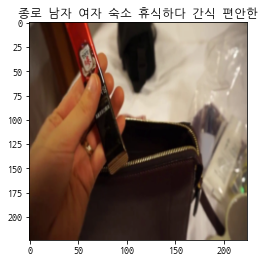

In [16]:
plt.rcParams["font.family"] = 'NanumGothicCoding' # 한글폰트 설정
train_dataset.show(22)

In [17]:
model = MultiTaskResnet34(len(where_unique), len(who_unique), len(recommend_place_unique), len(recommend_doing_unique), len(recommend_eat_unique), len(etc_unique))

In [18]:
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
model1 = train_model(model, criterion, optimizer, num_epochs=1)

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch 0/0
---------------


100%|██████████| 147/147 [06:59<00:00,  2.85s/it]


video108-01-frame8.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 5.2450 Mean_Acc: 0.7947  Where_Acc: 0.6158  Who_Acc: 0.7041 Place_Acc: 0.8377 Doing_Acc: 0.8902 Eat_Acc: 0.7971  Etc_Acc: 0.9236


100%|██████████| 28/28 [01:15<00:00,  2.70s/it]


video191-01-frame69.jpg
val Loss: 10.4029 Mean_Acc: 0.5182  Where_Acc: 0.2970  Who_Acc: 0.3564 Place_Acc: 0.5347 Doing_Acc: 0.6535 Eat_Acc: 0.4752  Etc_Acc: 0.7921

Training complete in 9m 5s
Best mean Val Accuracy: 0.518152


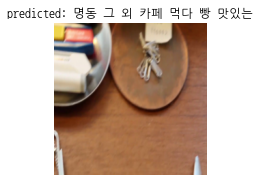

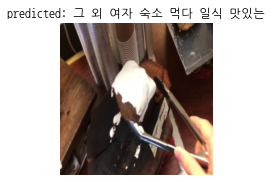

In [27]:
visualize_model(model1)

### Save and load the model

In [ ]:
torch.save(model1, 'weights/resnet34.pt')
model1 = torch.load('weights/resnet34.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수

### Train a model (Transfer learning)
- 이번엔 fc를 제외한 이전의 모든 layer를 freeze시키고 마지막 fc layer만 학습시켜보자
- 데이터셋이 작기 때문에 이 방법이 성능이 더 잘 나올수도 있다.
https://jeinalog.tistory.com/13

In [ ]:
# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layers
model.fc1.weight.requires_grad = True
model.fc2.weight.requires_grad = True
model.fc3.weight.requires_grad = True
model.fc4.weight.requires_grad = True
model.fc5.weight.requires_grad = True
model.fc6.weight.requires_grad = True

# optimizer
optimizer_fc = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

FC layer만 학습시키는 것이 조금 더 성능이 높게 나온다. (근데 거의 똑같음)
이전과 같이 한 epoch만에 수렴된다.

Data augmentation으로 데이터를 늘려서 다시 실험해보자

### 시도해볼것
- random seed가 고정이 되는지
- 코드 최대한 줄여보기
- 다른 알고리즘 적용해보기
- 하이퍼파라미터 조정해보기
- 비디오 classification 알고리즘 적용
- 코드 정리하기 (함수 만들기, 가독성 좋게 만들어보기)

In [ ]:
Hello